# Introduction


In this assignment, you will practice building and training Convolutional Neural Networks with Pytorch to solve computer vision tasks.  This assignment includes two sections, each involving different tasks:

(1) Image Classification. Predict image-level category labels on two historically notable image datasets: **CIFAR-10** and **MNIST**.

(2) Image Segmentation. Predict pixel-wise classification (semantic segmentation) on synthetic input images formed by superimposing MNIST images on top of CIFAR images.

You will design your own models in each section and build the entire training/testing pipeline with PyTorch. 
PyTorch provides optimized implementations of the building blocks and additional utilities, both of which will be necessary for experiments on real datasets. It is highly recommended to read the official [documentation](https://pytorch.org/docs/stable/index.html) and [examples](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) before starting your implementation. There are some APIs that you'll find useful:
[Layers](http://pytorch.org/docs/stable/nn.html),
[Activations](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity),
[Loss functions](http://pytorch.org/docs/stable/nn.html#loss-functions),
[Optimizers](http://pytorch.org/docs/stable/optim.html)

It is highly recommended to use Google Colab and run the notebook on a GPU node. Check https://colab.research.google.com/ and look for tutorials online. To use a GPU go to Runtime -> Change runtime type and select GPU. 


# (2) Image Segmentation
The task consists of performing pixel-wise classification on a synthetic dataset
of 32x32 RGB images. Each image was generated by placing a MNIST sample (a grayscale
image of a digit between 0 and 9) on top of a CIFAR-10 sample (a RGB image drawn from
one of 10 possible classes). Each image has an accompanying target tensor of size 32x32,
where in each pixel location (i,j) it contains the ground-truth label of the MNIST digit
(ranging from 0 to 9) or of the CIFAR-10 image (ranging from 10 to 19), depending on whether
the (i,j) pixel in the original image belongs to the superposed MNIST image or not. The
metric of interest here is pixel-wise accuracy, which is the fraction of pixels in each image
for which your model predicted the correct class (out of a total of 20 classes, as described 
above).

Note that there are many ways to frame the above task. For example, your CNN can directly
output a 20x32x32 tensor for each input image, representing a distribution over the possible
20 classes for each of the 32x32 pixels. However, note that the problem has a lot of additional
structure: for example, each 32x32 target tensor only has two distinct numbers in it, the label
of the MNIST digit and the label of the CIFAR-10 background image -- accounting for such
structure will make training faster and likely improve your model's final performance. Your
model should be able to achieve around 70% accuracy on the test set when trained for 100 epochs.

To finish this section step by step, you need to:

* Prepare data by building a dataset and data loader. (already provided below)

* Implement training code (6 points) & testing code (6 points), including saving and loading of models.

* Construct a model (12 points) and choose an optimizer (3 points).

* Describe what you did, any additional features you implemented, and/or any graphs you made in training and evaluating your network. Report final test accuracy @100 epochs in a writeup: hw3.pdf (3 points)

In [2]:
import numpy as np
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision
import torchvision.transforms as T
from utils import SegDataset

# Check GPU availability
assert torch.has_mps == True, "PyTorch not working on GPU"


## Data Preparation:

Setup a Dataset for training and testing.

Datasets load single training examples one a time, so we practically wrap each Dataset in a DataLoader, which loads a data batch in parallel.

In [3]:
batch_size = 128
seg_train = SegDataset('./data', train=True, transform=None)
loader_train = DataLoader(seg_train, batch_size=batch_size, shuffle=True)
seg_test = SegDataset('./data', train=False, transform=None)
loader_test = DataLoader(seg_test, batch_size=batch_size, shuffle=False)

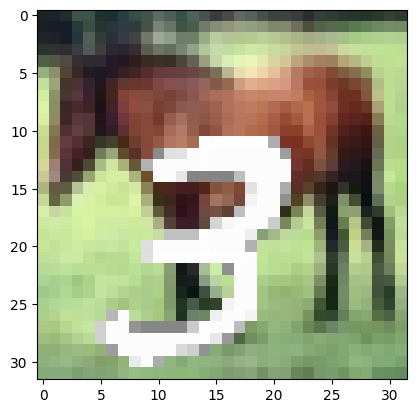

In [4]:
# View example image 
import matplotlib.pyplot as plt
plt.imshow(seg_train.data[7].permute(1, 2, 0))

tensor([ 3, 17])

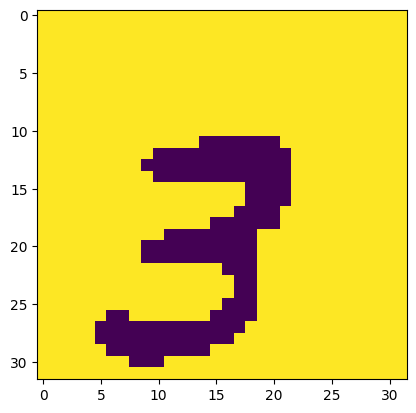

In [5]:
# View example segmentation
plt.imshow(seg_train.target[7])
seg_train.target[7].unique()

## Design/choose your own model structure (12 points) and optimizer (3 points).
You might want to adjust following configurations for better performance:

(1) Network architecture:
- You can borrow some ideas from existing convnets design, e.g., [ResNet](https://arxiv.org/abs/1512.03385) where
the input from the previous layer is added to the output, or [UNet](https://arxiv.org/pdf/1505.04597.pdf) where you can stack intermediate features from previous layers. 
- Note: Do not **directly copy** an existing network design.

(2) Architecture hyperparameters:
- Filter size, number of filters, and number of layers (depth). Make careful choices to tradeoff computational efficiency and accuracy.
- Pooling vs. Strided Convolution
- Batch normalization
- Choice of non-linear activation

(3) Choice of optimizer (e.g., SGD, Adam, Adagrad, RMSprop) and associated hyperparameters (e.g., learning rate, momentum).


In [6]:
##########################################################################
# TODO: YOUR CODE HERE
# (1) Complete the model
##########################################################################
class EncoderBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        kernel_size = 3
        padding = kernel_size // 2
        self.block = nn.Sequential(nn.Conv2d(in_ch, out_ch, kernel_size, 1, padding), 
                                   nn.BatchNorm2d(out_ch), 
                                   nn.ReLU(inplace=True),
                                   nn.Conv2d(out_ch, out_ch, kernel_size, 1, padding), # convolve
                                   nn.BatchNorm2d(out_ch), 
                                   nn.ReLU(inplace=True),
                                   nn.MaxPool2d(kernel_size = 2, stride = 2))
    
    def forward(self, x):
        return self.block(x)

class DecoderBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        up_kernel = 2
        kernel_size = 3
        padding = kernel_size // 2
        self.block = nn.Sequential(nn.Conv2d(in_ch, out_ch, kernel_size, 1, padding), # convolve increasing channels
                                   nn.BatchNorm2d(out_ch), 
                                   nn.ReLU(inplace=True),
                                   nn.ConvTranspose2d(out_ch, out_ch, up_kernel, 2), # upsample
                                   nn.BatchNorm2d(out_ch), 
                                   nn.ReLU(inplace=True),
                                   nn.Conv2d(out_ch, out_ch, kernel_size, 1, padding), # convolve
                                   nn.BatchNorm2d(out_ch), 
                                   nn.ReLU(inplace=True))
    
    def forward(self, x):
        return self.block(x)
      
class myNet(nn.Module):
    def __init__(self):
        super(myNet, self).__init__()
        # Set up your own CNN.
        channels = [3, 32, 64, 128, 256]
        self.encoders = nn.ModuleList([EncoderBlock(channels[i], channels[i+1]) \
                                       for i in range(len(channels) - 1)])

        type_decoder_channels = [256, 128, 64, 32, 2]
        self.type_decoder = nn.ModuleList([DecoderBlock(type_decoder_channels[i], type_decoder_channels[i+1]) \
                                       for i in range(len(type_decoder_channels) - 1)])
        class_decoder_channels = [256, 128, 64, 32, 10]
        self.class_decoder = nn.ModuleList([DecoderBlock(class_decoder_channels[i], class_decoder_channels[i+1]) \
                                       for i in range(len(class_decoder_channels) - 1)])

    def forward(self, x):
        # forward
        xs = []
        for enc in self.encoders:
            x = enc(x)
            xs.append(x)
        xs = xs[::-1]
        for i, (type_dec, class_dec) in enumerate(zip(self.type_decoder, self.class_decoder)):
            if i > 0: # add after first upsample
                x_type = type_dec(x_type + xs[i])
                x_class = class_dec(x_class + xs[i])
            else:
                x_type = type_dec(x)
                x_class = class_dec(x)

        # combine the two matrices into 1 segmentation
        return torch.concat((torch.mul(x_type[:,[0],:,:].repeat(1,10,1,1), x_class), \
                           torch.mul(x_type[:,[1],:,:].repeat(1,10,1,1), x_class)), dim  = 1) # batch_size x 20 x img_w x img_h size
        

## Training (6 points)

Train a model on the given dataset using the PyTorch Module API.

Inputs:
- loader_train: The loader from which train samples will be drawn from.
- loader_test: The loader from which test samples will be drawn from
- model: A PyTorch Module giving the model to train.
- optimizer: An Optimizer object we will use to train the model
- epochs: (Optional) A Python integer giving the number of epochs to train for

Returns: Nothing, but prints model accuracies during training.

In [7]:
def train(loader_train, loader_test, model, optimizer, device, epochs=100):
    model = model.to(device)
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    for e in range(epochs):
        model.train()
        epoch_loss = 0
        num_samples = 0
        num_correct = 0
        for t, (x, y) in enumerate(loader_train):
            ##########################################################################
            # TODO: YOUR CODE HERE
            # (1) move data to GPU
            # (2) forward and get loss
            # (3) zero out all of the gradients for the variables which the optimizer
            # will update.
            # (4) the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            # (5) update the parameters of the model using the gradients
            # computed by the backwards pass.
            ##########################################################################
            # move data to GPU 
            x = x.to(device)
            y = y.to(device) 
            
            y_hat = model(x)
            loss = torch.nn.functional.cross_entropy(y_hat, y)
            optimizer.zero_grad() # set gradients to 0

            loss.backward() # compute derivatives
            optimizer.step() # update parameters  

            # compute metrics
            epoch_loss += loss.item() * x.shape[0]
            _, y_tilde = torch.max(y_hat, 1) # predicted label
            # pixel-wise accuracy
            s = y.shape
            num_samples += np.prod(s)
            num_correct += (y_tilde == y).sum()


            if t % 100 == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))

        
        # Compute loss/accuracy metrics 
        train_acc.append((100 * num_correct / num_samples).tolist())
        train_loss.append(epoch_loss / len(loader_train.dataset))

        vl, va = test(loader_test, model, device)
        val_loss.append(vl)
        val_acc.append(va)
    
    return train_loss, val_loss, train_acc, val_acc



## Testing (6 points)
Test a model using the PyTorch Module API.

Inputs:
- loader: The loader from which test samples will be drawn from.
- model: A PyTorch Module giving the model to test.

Returns: Nothing, but prints model accuracies during training.

In [8]:
def test(loader, model, device):
    num_correct = 0
    num_samples = 0
    model.eval() # set model to evaluation mode
    loss = 0
    with torch.no_grad():
        for x, y in loader:
            ##########################################################################
            # TODO: YOUR CODE HERE
            # (1) move to GPU
            # (2) forward and calculate scores and predictions
            # (2) accumulate num_correct and num_samples
            ##########################################################################
            x = x.to(device)
            y = y.to(device)

            y_hat = model(x)
            loss += torch.nn.functional.cross_entropy(y_hat, y).item() * x.shape[0]
            _, y_tilde = torch.max(y_hat, 1) # predicted label
            # pixel-wise accuracy
            s = y.shape
            num_samples += np.prod(s)
            num_correct += (y_tilde == y).sum()
        
        # Print accuracy
        val_acc = 100 * num_correct / num_samples
        print('Eval %d / %d correct (%.2f)' % (num_correct, num_samples, val_acc))
        # Validation loss
        val_loss = loss / len(loader.dataset)
        return val_loss, val_acc.tolist()

Describe your design details in the writeup hw3.pdf. (3 points)

Finish your model and optimizer below.

In [9]:
device = torch.device("mps") # set GPU device

In [46]:
lr = 0.001
model = myNet()
optimizer = optim.Adam(model.parameters(), lr, (0.9, 0.999))
train_loss, val_loss, train_acc, val_acc = train(loader_train, loader_test, model, optimizer, device, epochs=100)

# Save model
torch.save(model.state_dict(),"img_seg_mdl.pt")
dummy_input = next(iter(loader_train))[0]
torch.onnx.export(model.cpu(), dummy_input, "seg_mdl.onnx", input_names=["Input image"], output_names=["Segmentation"])

Epoch 0, Iteration 0, loss = 3.1378
Epoch 0, Iteration 100, loss = 2.6203
Epoch 0, Iteration 200, loss = 2.2893
Epoch 0, Iteration 300, loss = 2.1492
Eval 3002371 / 10240000 correct (29.32)
Epoch 1, Iteration 0, loss = 2.1381
Epoch 1, Iteration 100, loss = 1.9367
Epoch 1, Iteration 200, loss = 1.9046
Epoch 1, Iteration 300, loss = 1.7711
Eval 4501502 / 10240000 correct (43.96)
Epoch 2, Iteration 0, loss = 1.6615
Epoch 2, Iteration 100, loss = 1.6567
Epoch 2, Iteration 200, loss = 1.4297
Epoch 2, Iteration 300, loss = 1.3884
Eval 5228542 / 10240000 correct (51.06)
Epoch 3, Iteration 0, loss = 1.4536
Epoch 3, Iteration 100, loss = 1.4529
Epoch 3, Iteration 200, loss = 1.1975
Epoch 3, Iteration 300, loss = 1.1470
Eval 5389316 / 10240000 correct (52.63)
Epoch 4, Iteration 0, loss = 1.2186
Epoch 4, Iteration 100, loss = 1.0291
Epoch 4, Iteration 200, loss = 1.1851
Epoch 4, Iteration 300, loss = 1.2677
Eval 6064100 / 10240000 correct (59.22)
Epoch 5, Iteration 0, loss = 1.0423
Epoch 5, Itera

In [47]:
import matplotlib.pyplot as plt

from matplotlib import rc
rc('text', usetex=True)
rc('font', size=14)
rc('legend', fontsize=13)
rc('text.latex', preamble=r'\usepackage{cmbright}')

def plot_train_val(train, val, title, ylabel):
    assert len(train) == len(val)
    epochs = list(range(len(train)))
    plt.plot(epochs, train, label = "Train")
    plt.plot(epochs, val, label = "Test")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

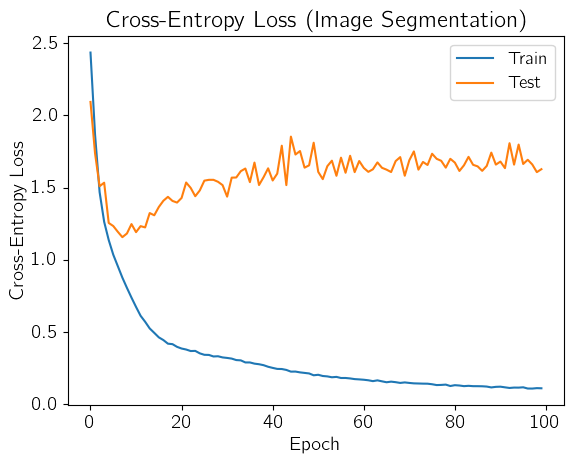

In [48]:
plot_train_val(train_loss, val_loss, "Cross-Entropy Loss (Image Segmentation)","Cross-Entropy Loss")

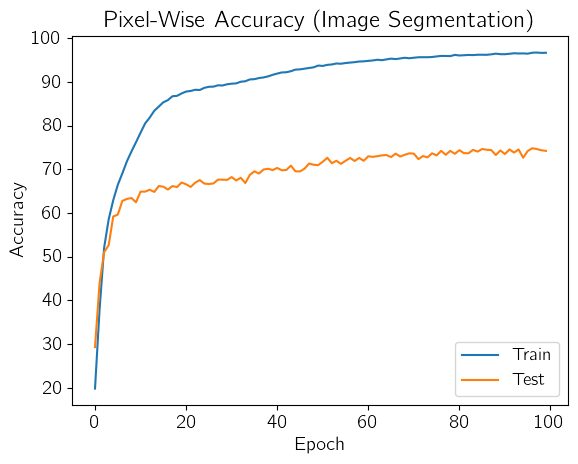

In [49]:
plot_train_val(train_acc, val_acc, "Pixel-Wise Accuracy (Image Segmentation)","Accuracy")

In [13]:
# Load saved neural net
model = myNet()
model.load_state_dict(torch.load("img_seg_mdl.pt"))
test(loader_test, model, torch.device("cpu"))

Eval 7602389 / 10240000 correct (74.24)


(1.627509277153015, 74.24208068847656)